# **Poisson Regression via `sklearn` and `statsmodels`**

## **0.** Settings

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model    import PoissonRegressor
from numpy.random            import uniform, poisson

import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import numpy as np
import statsmodels

%matplotlib inline

## **1.** Poisson distribution

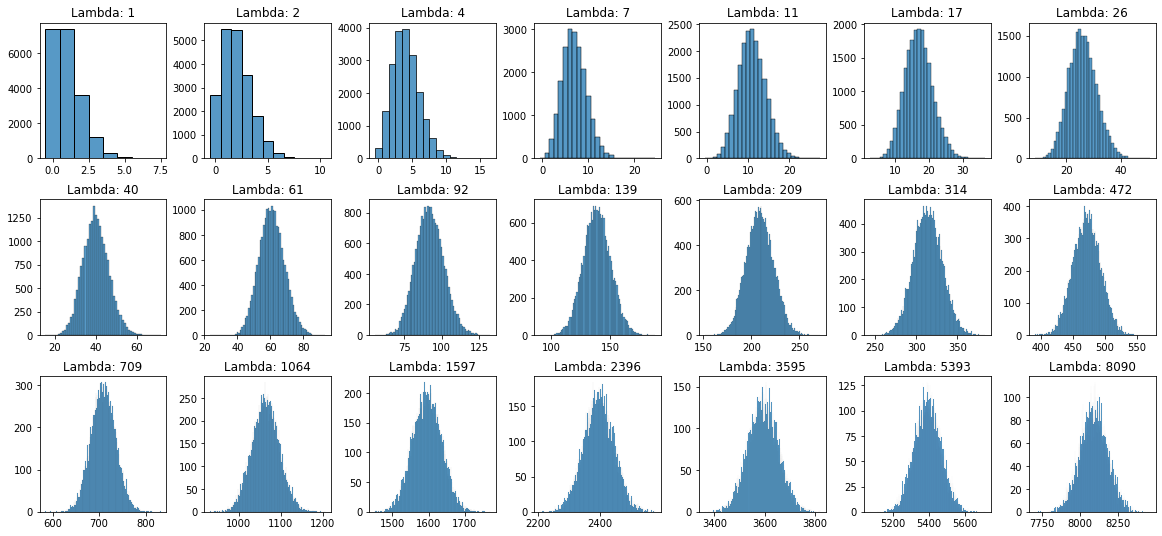

In [2]:
np.random.seed(42)

plt.figure(figsize=(20,9))

# Initial value of lambda
lambda_value = 0

# Number of rows and columns
n_rows = 3
n_cols = 7

for i in range(n_rows*n_cols):

    # Plot
    plt.subplot(n_rows, n_cols, i+1)
    
    # Increase lambda
    lambda_value = int(lambda_value + 1 + lambda_value*0.5)

    # Generate y_values
    y_values = np.random.poisson(lam=lambda_value, size=20000)
    sns.histplot(y_values, discrete=True)
    plt.title(f'Lambda: {lambda_value}')
    plt.xlabel(None)
    plt.ylabel(None)
    plt.xticks(None)

plt.subplots_adjust(wspace=.3, hspace=.3)

## **2.** Dataset

In the case of poisson regression $Y$ is a positive integer (count) and it is modeled as:

$\qquad
\begin{cases}
        \;Y \sim Poisson(\mu)\\
        \;\log(\mu) = \beta_0 + \beta_1 \cdot X\\
        \;\mu = e^{\beta_0 + \beta_1 \cdot X}\\
\end{cases}
$

In [3]:
np.random.seed(42)

# Parameters
n_sample = 500
beta_0   = -.5
beta_1   = .4
liminf_x = 1
limsup_x = 10

# Data simulation
x  = uniform(liminf_x, limsup_x, size=n_sample)
mu = np.exp(beta_0 + beta_1*x)
y  = poisson(mu)

## **3.** Poisson Regression with `sklearn`

True model: y ~ Poisson(μ)
True log(μ) = -0.5 + 0.4 * x
Regression log(μ) = -0.45 + 0.39 * x
Percentage of deviance explained (D^2): 0.8796


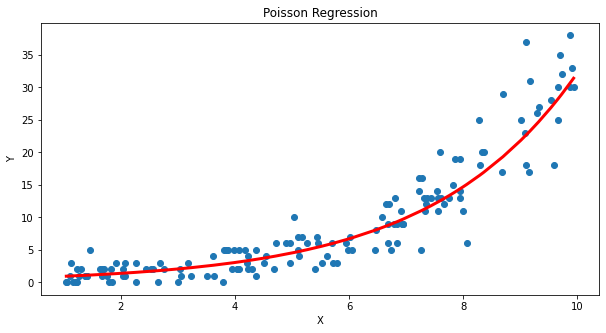

In [4]:
# Train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

# Poisson Regression
#   Note:   It is needed to give both the fit and predict methods 2D arrays. 
#           Right now x_train and x_test are currently only 1 dimensional.
#           What we shoudl do to fix it is: 
x_train = x_train.reshape(-1, 1)

# Create linear regression object
model = PoissonRegressor()

# Train the model using the training sets
model.fit(x_train, y_train);

# Make predictions using the testing set
y_pred = model.predict(x_test.reshape(-1, 1))

# The coefficients
print('True model: y ~ Poisson(μ)')
print('True log(μ) =', beta_0, '+', beta_1, '* x')
print('Regression log(μ) = %.2f' % model.intercept_, '+ %.2f' % model.coef_[0], '* x')

# Percentage of deviance explained (D^2)
print('Percentage of deviance explained (D^2): %.4f' % model.score(x_test.reshape(-1, 1), y_test))

# Plot outputs
plt.figure(figsize=(10,5));
plt.scatter(x_test, y_test)
plt.plot(x_test[x_test.argsort()], y_pred[x_test.argsort()], color='red', linewidth=3);
plt.title('Poisson Regression');
plt.xlabel('X');
plt.ylabel('Y');

The percentage of deviance explained, $D^2$, is a generalization of the coefficient of determination $R^2$ (from linear regression). 

The percentage of deviance explained is calculated as $D^2 = 1-\frac{D(y_{true}, y_{pred})}{D_{null}}$, where $D(\cdot,\cdot)$ is the deviance function calculated (in the Poisson case) as $D(y_{true}, y_{pred}) = \frac{1}{N}\,\sum_{i=1}^N 2\,(y_{true_i}\log(\frac{y_{true_i}}{y_{pred_i}}) + y_{pred} - y_{trye})$, and $D_{null} = D(y_{true}, \bar{y})$ (where $\bar{y}$ is the mean of the samples). 

The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse).

## **4.** Poisson Regression with `statsmodels`

In [5]:
# Train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

# To have the intercept in the model
x_train = sm.add_constant(x_train)

# Poisson Regression
model = statsmodels.discrete.discrete_model.Poisson(y_train, x_train)
model = model.fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 2.237265
         Iterations 6
                          Poisson Regression Results                          
Dep. Variable:                      y   No. Observations:                  350
Model:                        Poisson   Df Residuals:                      348
Method:                           MLE   Df Model:                            1
Date:                Wed, 15 Jun 2022   Pseudo R-squ.:                  0.6353
Time:                        16:17:29   Log-Likelihood:                -783.04
converged:                       True   LL-Null:                       -2147.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5341      0.073     -7.272      0.000      -0.678      -0.390
x1             0.4029      0.

Some statistical tests.

* **LogLikelihood Ratio (LLR) test**<br>
$\quad$ `LLR p-value = 0.000` <br>
This test has as $H_0$ the hypothesis that the model should be simplified, as $H_1$ the hypothesis that the model is good as it is. If the p-value of this test is significantly small, then one can conclude that the predictor or set of predictors significantly improve the model's fit. This is analogous to the F-test used in linear regression analysis to assess the significance of prediction.

* **Z-test for the intercept and the coefficients**<br>
$\quad$ **`Intercept`** $\;$ `p-value = P>|t| = 0.00`<br>
$\quad$ **`Coefficient`** $\;$ `p-value = P>|t| = 0.00`<br>
The z-test helps to determine the correlation between the response and the predictor variables. The test is used in regression to test the null hypothesis $H_0$ that the slope or the coefficient is equal to zero.

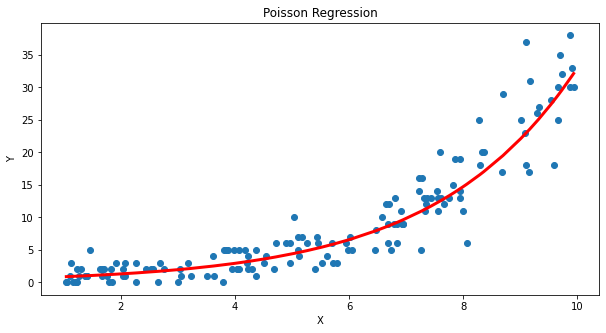

In [6]:
# Regression Line
y_pred = model.predict(sm.add_constant(x_test))

idx = x_test.argsort()
x_test_ord, y_pred_ord = x_test[idx], y_pred[idx]

# Plot
plt.figure(figsize=(10,5));
plt.scatter(x_test, y_test);
plt.plot(x_test_ord, y_pred_ord, color='red', linewidth=3);
plt.title('Poisson Regression');
plt.xlabel('X');
plt.ylabel('Y');